<h1 style="font-size:3rem;color:orange;">Directing User Subscriptions</h1>

<h2 style="font-size:2rem;color:orange;">Data Pre-processing and Model Building</h2>

### Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import time

### Import Data

In [2]:
df_users = pd.read_csv("../data/processed/new_app-user-data.csv")

### Data Peek

In [3]:
df_users.head()

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,location,...,SecurityModal,ResendToken,TransactionList,NetworkFailure,ListPicker,OtherScreens,SavingsScreens,CreditMonitoringScreens,CreditCardScreens,LoanScreens
0,235136,3,2,23,15,0,0,0,0,0,...,0,0,0,0,0,7,0,0,0,1
1,333588,6,1,24,13,0,0,0,0,1,...,0,0,0,0,0,5,0,0,0,1
2,254414,1,19,23,3,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,234192,4,16,28,40,0,0,1,0,1,...,0,0,0,0,0,6,0,3,0,1
4,51549,1,18,31,32,0,0,1,1,0,...,0,0,0,0,0,10,0,2,0,1


# Data Pre-processing

### Remove the label from the features

In [4]:
label = df_users['enrolled']
df_users = df_users.drop(columns = 'enrolled')

### Split the dataset into training and test sets

In [5]:
from sklearn.model_selection import train_test_split

# Split the data into an 80/20 train/test ratio
X_train, X_test, y_train, y_test = train_test_split(df_users, label,
                                                    test_size = 0.2,
                                                    random_state = 2)
print(X_train.shape)
print(X_test.shape)

(39773, 49)
(9944, 49)


### Filter model data

In [6]:
# Purge user identification, persist to associate the prediction to the user it came from 
train_identifier = X_train['user']
X_train = X_train.drop(columns = ['user'])

test_identifier = X_test['user']
X_test = X_test.drop(columns = ['user'])

Next, we selectively exclude features discovered in model building to have a high p-value 

In [7]:
drop_features = ['liked', 'Cycle', 'Leaderboard', 'RewardDetail', 'ProfileChildren ', 'ProfileEducation', 'ProfileEducationMajor', 'ProfileJobTitle']

# Drop the features we discovered to have high p-values
X_train = X_train.drop(columns = drop_features)
X_test = X_test.drop(columns = drop_features)
df_users = df_users.drop(columns = drop_features)

### Feature Scaling

In [8]:
from sklearn.preprocessing import StandardScaler

# To normalize features
standard_scaler_X = StandardScaler()

# Scale the training & test datasets, persist results to a new dataframe
X_train2 = pd.DataFrame(standard_scaler_X.fit_transform(X_train))
X_test2 = pd.DataFrame(standard_scaler_X.transform(X_test))

# Retrieve columns for the standardized training & test sets 
X_train2.columns = X_train.columns.values
X_test2.columns = X_test.columns.values

# Recuperate indexes 
X_train2.index = X_train.index.values
X_test2.index = X_test.index.values

# Convert original training set into the new training set
X_train = X_train2
X_test = X_test2

X_train.head()

,dayofweek,hour,age,numscreens,minigame,used_premium_feature,location,Institutions,VerifyPhone,BankVerification,...,SecurityModal,ResendToken,TransactionList,NetworkFailure,ListPicker,OtherScreens,SavingsScreens,CreditMonitoringScreens,CreditCardScreens,LoanScreens
9273,-0.997518,-0.475808,-1.178396,0.859112,-0.346256,-0.457022,0.969514,1.558621,0.955650,-0.685306,...,-0.120366,-0.115097,-0.11249,-0.089491,-0.087762,0.495931,-0.254394,2.536368,-0.282949,0.316040
15380,0.969477,0.195495,-0.256986,-0.393123,-0.346256,2.188079,-1.031445,-0.641593,-1.046408,-0.685306,...,-0.120366,-0.115097,-0.11249,-0.089491,-0.087762,-1.145831,-0.254394,-0.760519,-0.282949,1.791375
23862,-0.505769,-0.610069,-1.086255,2.459190,-0.346256,-0.457022,0.969514,1.558621,0.955650,-0.685306,...,-0.120366,-0.115097,-0.11249,-0.089491,-0.087762,0.769559,-0.254394,0.063703,-0.282949,0.316040
37696,-0.997518,-1.415633,1.954397,0.859112,-0.346256,-0.457022,0.969514,-0.641593,0.955650,-0.685306,...,-0.120366,-0.115097,-0.11249,-0.089491,-0.087762,-0.324950,1.223228,-0.760519,-0.282949,-1.159295
13372,-0.014021,0.329756,0.111578,-1.019241,-0.346256,-0.457022,-1.031445,-0.641593,-1.046408,-0.685306,...,-0.120366,-0.115097,-0.11249,-0.089491,-0.087762,-0.598577,-0.254394,-0.760519,-0.282949,-1.159295


# Model Building

## Training

In [22]:
from sklearn.linear_model import LogisticRegression

# Add 'l1' penalty (lasso regularization) for screen correlation
model = LogisticRegression(random_state=2, C=10, penalty='l1', solver="saga")

# Train model on the training set
model.fit(X_train, y_train)

LogisticRegression(C=10, penalty='l1', random_state=2, solver='saga')

## Evaluation

### Confusion Matrix and Scores

Accuracy Score:  0.77142
Precision Score: 0.76261
Recall Score:    0.77803
F1 Score:        0.77024


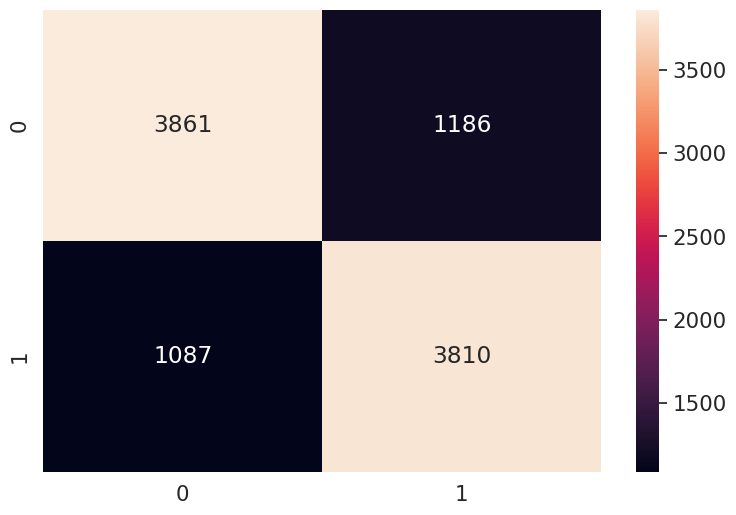

In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# Make predictions from test set
y_predict = model.predict(X_test)

# Create a confusion matrix with test labels and our model's predictions
conf_matrix = confusion_matrix(y_test, y_predict)

# Plot confusion matrix
df_conf_matrix = pd.DataFrame(conf_matrix, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (9,6))
sn.set(font_scale=1.4)
sn.heatmap(df_conf_matrix, annot=True, fmt='g')

# Display scores
print(f"Accuracy Score:  {accuracy_score(y_test, y_predict):.5f}")  # NumCorrectPredicts / TotalNumPredicts
print(f"Precision Score: {precision_score(y_test, y_predict):.5f}") # TP / (TP + FP)
print(f"Recall Score:    {recall_score(y_test, y_predict):.5f}")    # TP / (TP + FN)
print(f"F1 Score:        {f1_score(y_test, y_predict):.5f}")        # 2 * (precision * recall) / (precision + recall)

### K-Fold Cross Validation

Estimate how well the model is likely to generalize to unseen data

In [24]:
from sklearn.model_selection import cross_val_score

# Perform k-fold cross-validation, here with 10 folds
accuracies = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10)

print("Cross Validated Scores Mean: %0.5f Std: (+/- %0.5f)" % (accuracies.mean(), accuracies.std() * 2))

Cross Validated Scores Mean: 0.76823 Std: (+/- 0.01479)


### Analyze Coefficients

In [12]:
# Analyze model coefficients
df_coefficients = pd.concat([pd.DataFrame(X_train.columns, columns = ["features"]),
           pd.DataFrame(np.transpose(model.coef_), columns = ["coef"])
           ],axis = 1)

# Display (adjust as needed)
df_coefficients.head()

,features,coef
0,dayofweek,0.030616
1,hour,-0.013509
2,age,-0.149127
3,numscreens,-0.106426
4,minigame,-0.027510


Calculate **p-values** from our sklearn model: Perform permutation testing to approximate
(This may take some time)

In [13]:
from sklearn.utils import resample

# Number of permutations (adjust as needed)
n_permutations = 1000
# Flatten the coefficient array
coefs = model.coef_.ravel()  
# Create an array to store permuted coefficients
permuted_coefs = np.zeros((n_permutations, len(coefs)))

# Perform permutation testing
for i in range(n_permutations):
    # Resample the feature matrix while keeping the target variable unchanged
    X_permuted = resample(X_train)
    # Fit the logistic regression model on the permuted data
    model.fit(X_permuted, y_train)
    # Record the permuted coefficients in the permuted_coefs array
    permuted_coefs[i] = model.coef_.ravel()

# Calculate the p-values
p_values = np.mean(np.abs(permuted_coefs) >= np.abs(coefs), axis=0)

# Add the p-values to the coefficient DataFrame
df_coefficients['p-value'] = p_values

In [19]:
# Display p-values (adjust as needed)
df_coefficients.head()

,features,coef,p-value
0,dayofweek,0.030616,0.002
1,hour,-0.013509,0.190
2,age,-0.149127,0.000
3,numscreens,-0.106426,0.000
4,minigame,-0.027510,0.006


## Model Tuning

### Grid Search: Round One

In [15]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
parameter_grid = {
    # Select regularization methods
    'penalty': ['l1', 'l2'],
    # Create regularization hyperparameter space
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    # Specify the solvers to be tuned
    'solver': ['liblinear', 'saga'] 
}

grid_search = GridSearchCV(estimator = model,
                           param_grid = parameter_grid,
                           scoring = "accuracy",
                           cv = 10,
                           n_jobs = -1)
start_time = time.time()
grid_search = grid_search.fit(X_train, y_train)
end_time = time.time()

rf_best_accuracy1 = grid_search.best_score_
rf_best_parameters1 = grid_search.best_params_

print("Round One Time: %0.2f seconds" % (end_time - start_time))
print("Round One Best Accuracy:", rf_best_accuracy1)
print("Round One Best Hyperparameters:", rf_best_parameters1)

Round One Time: 28.35 seconds
Round One Best Accuracy: 0.7682346127235122
Round One Best Hyperparameters: {'C': 10, 'penalty': 'l1', 'solver': 'saga'}


### Grid Search: Round Two

In [16]:
# Define the hyperparameter grid
parameter_grid = {
    # Select regularization methods
    'penalty': ['l1', 'l2'],
    # Create regularization hyperparameter space
    'C': [0.1, 1, 10, 100, 1000],
    # Specify the solvers to be tuned
    'solver': ['liblinear', 'saga'] 
}

grid_search = GridSearchCV(estimator = model,
                           param_grid = parameter_grid,
                           scoring = "accuracy",
                           cv = 10,
                           n_jobs = -1)
start_time = time.time()
grid_search = grid_search.fit(X_train, y_train)
end_time = time.time()

rf_best_accuracy2 = grid_search.best_score_
rf_best_parameters2 = grid_search.best_params_

print("Round Two Time: %0.2f seconds" % (end_time - start_time))
print("Round Two Best Accuracy:", rf_best_accuracy2)
print("Round Two Best Hyperparameters:", rf_best_parameters2)

Round Two Time: 21.19 seconds
Round Two Best Accuracy: 0.7682346127235122
Round Two Best Hyperparameters: {'C': 10, 'penalty': 'l1', 'solver': 'saga'}


## Final Model Training

## Save Model

In [25]:
import os
import pickle

# Create a directory to save the model if it doesn't exist
directory = "../models"
if not os.path.exists(directory):
    os.makedirs(directory)

# Save the model to the specified directory
filename = os.path.join(directory, 'sklearn_model.pkl')
with open(filename, 'wb') as file:
    pickle.dump(model, file)